# Importing Packages

In [2]:
import requests
import json
from io import StringIO
from bs4 import BeautifulSoup as bs
from datetime import date, timedelta
import covidcast

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

import pickle

from sklearn.pipeline import Pipeline 
from sklearn.impute import KNNImputer, SimpleImputer 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier



# Data Collection

- Dataset was orignally constructed (webscraping/api calls) made and relevant to classification.  At least 1000 rows and at least 10 features.

# Exploratory Data Analysis

- Student created at least 2 well-constructed visualizations, discussed descriptive statistics, and is able to interpret and compare or link them together to give a cohesive introduction to the data


## Geopandas File for Mapping

In [33]:
data = gpd.read_file('https://services9.arcgis.com/6Hv9AANartyT7fJW/arcgis/rest/services/USCounties_cases_V1/FeatureServer/0/query?where=1%3D1&outFields=Countyname,FIPS,Shape__Area,Shape__Length,ST_Name,ST_Abbr,ST_ID,OBJECTID&outSR=4326&f=json')

## NYT Mask Wearing Survey Data

- This data comes from a large number of interviews conducted online by the global data and survey firm Dynata at the request of The New York Times. 
- The firm asked a question about mask use to obtain 250,000 survey responses between July 2 and July 14, enough data to provide estimates more detailed than the state level. - (Several states have imposed new mask requirements since the completion of these interviews.)

Specifically, each participant was asked: 

*How often do you wear a mask in public when you expect to be within six feet of another person?*

This survey was conducted a single time, and at this point we have no plans to update the data or conduct the survey again.

The fields have the following definitions:

- **COUNTYFP**: The county FIPS code.
- **NEVER**: The estimated share of people in this county who would say never in response to the question: “How often do you wear a mask in public when you expect to be within six feet of another person?”
- **RARELY**: The estimated share of people in this county who would say rarely
- **SOMETIMES**: The estimated share of people in this county who would say sometimes
- **FREQUENTLY**: The estimated share of people in this county who would say frequently
- **ALWAYS**: The estimated share of people in this county who would say always


In [3]:
url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/mask-use/mask-use-by-county.csv'
s = requests.get(url).text
nymask = pd.read_csv(StringIO(s))
nymask.COUNTYFP = nymask.COUNTYFP.astype(str)
nymask.COUNTYFP = np.where(nymask['COUNTYFP'].str.len() == 4, '0' + nymask.COUNTYFP, nymask.COUNTYFP)
nymask.columns = ['FIPS', 'NEVER', 'RARELY', 'SOMETIMES', 'FREQUENTLY', 'ALWAYS']
nymask.head()

,FIPS,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
0,01001,0.053,0.074,0.134,0.295,0.444
1,01003,0.083,0.059,0.098,0.323,0.436
2,01005,0.067,0.121,0.120,0.201,0.491
3,01007,0.020,0.034,0.096,0.278,0.572
4,01009,0.053,0.114,0.180,0.194,0.459


In [4]:
# fig, ax = plt.subplots(1, figsize=(20,20))
# merged.plot(column='trump_pct', cmap='RdBu_r', linewidth=0.8, ax=ax, edgecolor='black')
# # ax.axis('off')
# # ax.set_title('Percentage By County for 2016 Election', fontsize=18)
# # plt.savefig('images/election2016.png')

<img src='images/fb_mask_data.png'>

## Carnegie Mellon Mask Wearing Facebook Survey Data

Between the new survey’s deployment on September 8, 2020, and October 7th, the study collected 1,220,000 valid responses from respondents across the United States. 
Each response includes questions about symptoms, mask wearing, testing, and the other important topics described above, along with demographic details about the respondent. These demographics include age, gender, race, occupation, and education, allowing us to understand how different groups have been affected and which groups are currently most vulnerable to COVID-19. 

- **smoothed_wearing_mask**
  - Estimated percentage of people who wore a mask for most or all of the time while in public in the past 5 days; those not in public in the past 5 days are not counted.	

- **smoothed_others_masked**
  - Estimated percentage of respondents who say that most or all other people wear masks, when they are in public and social distancing is not possible


In [5]:
# create variable to hold date object for two days ago
two_days_ago = date.today() - timedelta(days=2)

In [6]:
# get the most recent survey data
mask_ind = covidcast.signal("fb-survey", "smoothed_wearing_mask",
                            date(2020, 10, 1), two_days_ago,
                            "county")
mask_oth = covidcast.signal('fb-survey', 'smoothed_others_masked', 
                            date(2020, 11, 24),two_days_ago, 
                            "county")

In [7]:
# remove data that isn't at the county level
mask_fip = mask_ind.loc[~mask_ind.geo_value.str.endswith('000')]
mask_oth = mask_oth.loc[~mask_oth.geo_value.str.endswith('000')]

In [11]:
# check number of counties represented 
print(mask_ind.geo_value.value_counts().shape)
print(mask_fip.geo_value.value_counts().shape)
mask_oth.geo_value.value_counts().shape

(726,)
(677,)


(655,)

In [12]:
# pare down datasets to just columns of interest
mask_ind_means = pd.DataFrame(mask_fip.groupby(['geo_value'])['value'].mean()).reset_index()
mask_ind_means.columns = ['FIPS', 'ind_mask']
mask_ind_means['FIPS'] = mask_ind_means['FIPS'].astype(int)
# repeat for other survey
mask_oth_means = pd.DataFrame(mask_oth.groupby(['geo_value'])['value'].mean()).reset_index()
mask_oth_means.columns = ['FIPS', 'oth_mask']
mask_oth_means['FIPS'] = mask_oth_means['FIPS'].astype(int)

<img src='images/delphi_dec.png'>

In [13]:
mask_ind_means.head()

,FIPS,ind_mask
0,1003,79.671626
1,1051,88.291970
2,1069,85.591414
3,1073,91.454122
4,1081,89.816314


In [14]:
mask_ind_means.FIPS = mask_ind_means.FIPS.astype(str)
mask_ind_means.FIPS = mask_ind_means.FIPS.apply(lambda x: x.zfill(5))
mask_oth_means['FIPS'] = mask_oth_means['FIPS'].astype(str)
mask_oth_means.FIPS = mask_oth_means.FIPS.apply(lambda x: x.zfill(5))

## Johns Hopkins COVID Data Geopandas

This feature layer contains the most up-to-date COVID-19 cases for the US. Data is pulled from the Coronavirus COVID-19 Global Cases by the Center for Systems Science and Engineering (CSSE) at Johns Hopkins University, the Red Cross, the Census American Community Survey, and the Bureau of Labor and Statistics, and aggregated at the US county level. 

This web map created and maintained by the Centers for Civic Impact at the Johns Hopkins University, and is supported by the Esri Living Atlas team and JHU Data Services. It is used in the COVID-19 United States Cases by County dashboard. 

 For more information on Johns Hopkins University’s response to COVID-19, visit the Johns Hopkins Coronavirus Resource Center where our experts help to advance understanding of the virus, inform the public, and brief policymakers in order to guide a response, improve care, and save lives.


In [15]:
geo = gpd.read_file('https://opendata.arcgis.com/datasets/4cb598ae041348fb92270f102a6783cb_0.geojson')
print(geo.shape)
geo.head()

(3331, 88)


,OBJECTID,Countyname,ST_Name,ST_Abbr,ST_ID,FIPS,FatalityRa,Confirmedb,DeathsbyPo,PCTPOVALL_,Unemployme,Med_HH_Inc,State_Fata,DateChecke,EM_type,EM_date,EM_notes,url,Thumbnail,Confirmed,Deaths,Age_85,Age_80_84,Age_75_79,Age_70_74,Age_65_69,Beds_Licen,Beds_Staff,Beds_ICU,Ventilator,POP_ESTIMA,POVALL_201,Unemployed,Median_Hou,Recovered,Active,State_Conf,State_Deat,State_Reco,State_Test,AgedPop,NewCases,NewDeaths,TotalPop,NonHispWhP,BlackPop,AmIndop,AsianPop,PacIslPop,OtherPop,TwoMorPop,HispPop,Wh_Alone,Bk_Alone,AI_Alone,As_Alone,NH_Alone,SO_Alone,Two_More,Not_Hisp,Age_Less15,Age_15_24,Age_25_34,Age_Over75,Agetotal,NonHisp,Age_35_64,Age_65_74,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6,Day_7,Day_8,Day_9,Day_10,Day_11,Day_12,Day_13,Day_14,NewCasebyP,Inpat_Occ,ICU_Occ,Shape__Area,Shape__Length,geometry
0,1,Autauga,Alabama,AL,01,01001,1.076426,8354.17,89.926440,13.8,3.6,118.9591,1.299898,01/07/2021 11:30:49,Govt Ordered Community Quarantine,4/3/2020 10:40:51 PM,AL Governor issued a Shelter In Place order.,https://bao.arcgis.com/covid-19/jhu/county/010...,https://coronavirus.jhu.edu/static/media/dashb...,4645,50,815,1026,1498,2440,2271,85,55,6,2,55601,7587,942,59338,0,0,384184,4994,0,1997125,8050,99,0,55200,41412,10475,159,568,5,41,1012,1528,42437,10565,159,568,32,409,1030,53672,10842,7192,7064,3339,55200,1528,22052,4711,99.0,210.0,31.0,37.0,29.0,49.0,26.0,59.0,40.0,36.0,30.0,9.0,48.0,53.0,178.054352,96.320346,100.000000,2.209382e+09,246839.865479,"POLYGON ((-86.41312 32.70739, -86.41219 32.526..."
1,2,Baldwin,Alabama,AL,01,01003,1.166758,6722.26,78.432452,9.8,3.6,115.4508,1.299898,01/07/2021 11:30:49,Govt Ordered Community Quarantine,4/3/2020 10:41:19 PM,AL Governor issued a Shelter In Place order.,https://bao.arcgis.com/covid-19/jhu/county/010...,https://coronavirus.jhu.edu/static/media/dashb...,14656,171,3949,4792,7373,11410,13141,386,362,51,8,218022,21069,3393,57588,0,0,384184,4994,0,1997125,40665,216,2,208107,172768,19529,1398,1668,9,410,2972,9353,179526,19764,1522,1680,9,2034,3572,198754,37621,23497,23326,16114,208107,9353,82998,24551,216.0,253.0,123.0,109.0,132.0,222.0,209.0,220.0,210.0,137.0,117.0,42.0,145.0,200.0,99.072571,74.029401,120.089286,5.770469e+09,728445.072448,"MULTIPOLYGON (((-87.78878 31.29877, -87.78849 ..."
2,3,Barbour,Alabama,AL,01,01005,2.191609,6418.55,140.669587,30.9,5.2,68.9280,1.299898,01/07/2021 11:30:49,Govt Ordered Community Quarantine,4/3/2020 10:43:21 PM,AL Governor issued a Shelter In Place order.,https://bao.arcgis.com/covid-19/jhu/county/010...,https://coronavirus.jhu.edu/static/media/dashb...,1597,35,422,551,841,1305,1515,74,30,5,2,24881,6788,433,34382,0,0,384184,4994,0,1997125,4634,22,2,25782,11898,12199,63,85,1,86,344,1106,12216,12266,72,96,1,778,353,24676,4517,3092,3675,1814,25782,1106,9864,2820,22.0,42.0,3.0,2.0,11.0,3.0,22.0,30.0,45.0,11.0,8.0,2.0,6.0,7.0,88.420883,56.711409,88.571429,3.258643e+09,307285.154510,"POLYGON ((-85.25609 32.13767, -85.25569 32.135..."
3,4,Bibb,Alabama,AL,01,01007,2.469136,8678.57,214.285714,21.8,4.0,92.3478,1.299898,01/07/2021 11:30:49,Govt Ordered Community Quarantine,4/3/2020 10:40:51 PM,AL Governor issued a Shelter In Place order.,https://bao.arcgis.com/covid-19/jhu/county/010...,https://coronavirus.jhu.edu/static/media/dashb...,1944,48,427,488,624,842,1280,35,25,4,1,22400,4400,344,46064,0,0,384184,4994,0,1997125,3661,21,2,22527,16801,4974,8,37,0,0,160,547,17268,5018,8,37,0,9,187,21980,3742,3005,3075,1539,22527,547,9044,2122,21.0,38.0,3.0,19.0,9.0,20.0,17.0,25.0,30.0,16.0,7.0,14.0,14.0,28.0,93.750000,19.047619,NaN,2.310715e+09,227886.963840,"POLYGON ((-87.02685 33.24646, -87.02572 33.209..."
4,5,Blount,Alabama,AL,01,01009,1.367905,8468.19,115.836791,13.2,3.5,101.0645,1.299898,01/07/2021 11:30:49,Govt Ordered Community Quarantine,4/3/2020 10:40:51 PM,AL Governor issued a Shelter In Place order.,https://bao.arcgis.com/covid-19/jhu/county/010...,https://coronavirus.jhu.edu/static/media/dashb...,4898,67,866,1459,1776,2802,3330,25,25,6,2,57840,7527,878,50412,0,0,384184,4994,

- FatalityRa = County Fatality Rate
- Confirmedb = County Confirmed divided by County Population * 100,000
- DeathsbyPo = County Deaths divided by County Population * 100,000
- Unemployme = Unemployment Rate
- EM_type, EM_date, EM_notes - could be turned into a column about Emergency Declaration
- Confirmed = County Level Confirmed Cases
- Deaths = County Level Deaths
- Beds_Licen = Number of Licensed Beds 
- Beds_Staff = Number of Staffed Beds 
- Beds_ICU = Number of ICU Beds 
- Ventilator = Average Ventilation Used Per Hospital
- POP_ESTIMA = Total Population
- POVALL_201 = Poverty Rate
- Median_Hou - Median Household Income
- Recovered = Number of Recovered Cases
- Active = Number of Active Cases
- AgedPop = TOtal Population Aged 65 Plus
- NewCases = New cases since yesterday
- NewDeaths = Newdeaths since yesterday
- Wh_Alone, Bk_Alone, AI_Alone, As_Alone, NH_Alone, SO_Alone, Two_More, Not_Hisp = Population numbers of each group
- Age_? = Population numbers of age groups
- NewCasebyP = I think this is new case by percentage
- ICU_Occ, Inpat_Occ = Percent Occupied of ICUs and Inpatient Beds
- Shape_Area, Shape_Length = for mapping



In [16]:
# remove all the rows with Unassigned and Out of [State] designations for county name, as well as Puerto Rico
geo = geo[~geo.Countyname.str.contains("Out of")]
geo = geo[~geo.Countyname.str.contains("Unassigned")]
geo = geo[~geo.ST_Name.str.contains("Puerto Rico")]
geo.drop(geo.tail(7).index, inplace=True)

In [17]:
# remove Day_1 to Day_14 columns, unclear what the days represent
geo.drop(columns=['Day_1', 'Day_2', 'Day_3', 'Day_4', 'Day_5', 'Day_6', 'Day_7', 'Day_8', 'Day_9', 'Day_10', 'Day_11', 'Day_12', 'Day_13', 'Day_14'], inplace=True)
# State level data columns were dropped, as well as any ID and repeated population data
geo.drop(columns=['OBJECTID', 'ST_ID', 'Med_HH_Inc', 'State_Fata', 'DateChecke', 'url', 'Thumbnail', 'State_Conf', 'State_Deat', 'State_Reco', 'State_Test'], inplace=True)
# Kept Deaths per 
geo.drop(columns=['Confirmed', 'Deaths', 'EM_notes'], inplace=True)

In [18]:
geo.EM_type = geo.EM_type.replace({'Govt Ordered Community Quarantine': 'CQ', 'Govt Directed Social Distancing': 'SD'})
geo.EM_date = geo.EM_date.str.extract(r'((\d+)\/(\d{2})\/(\d{4}))')

In [19]:
geo.head()

,Countyname,ST_Name,ST_Abbr,FIPS,FatalityRa,Confirmedb,DeathsbyPo,PCTPOVALL_,Unemployme,EM_type,EM_date,Age_85,Age_80_84,Age_75_79,Age_70_74,Age_65_69,Beds_Licen,Beds_Staff,Beds_ICU,Ventilator,POP_ESTIMA,POVALL_201,Unemployed,Median_Hou,Recovered,Active,AgedPop,NewCases,NewDeaths,TotalPop,NonHispWhP,BlackPop,AmIndop,AsianPop,PacIslPop,OtherPop,TwoMorPop,HispPop,Wh_Alone,Bk_Alone,AI_Alone,As_Alone,NH_Alone,SO_Alone,Two_More,Not_Hisp,Age_Less15,Age_15_24,Age_25_34,Age_Over75,Agetotal,NonHisp,Age_35_64,Age_65_74,NewCasebyP,Inpat_Occ,ICU_Occ,Shape__Area,Shape__Length,geometry
0,Autauga,Alabama,AL,01001,1.076426,8354.17,89.926440,13.8,3.6,CQ,NaN,815,1026,1498,2440,2271,85,55,6,2,55601,7587,942,59338,0,0,8050,99,0,55200,41412,10475,159,568,5,41,1012,1528,42437,10565,159,568,32,409,1030,53672,10842,7192,7064,3339,55200,1528,22052,4711,178.054352,96.320346,100.000000,2.209382e+09,246839.865479,"POLYGON ((-86.41312 32.70739, -86.41219 32.526..."
1,Baldwin,Alabama,AL,01003,1.166758,6722.26,78.432452,9.8,3.6,CQ,NaN,3949,4792,7373,11410,13141,386,362,51,8,218022,21069,3393,57588,0,0,40665,216,2,208107,172768,19529,1398,1668,9,410,2972,9353,179526,19764,1522,1680,9,2034,3572,198754,37621,23497,23326,16114,208107,9353,82998,24551,99.072571,74.029401,120.089286,5.770469e+09,728445.072448,"MULTIPOLYGON (((-87.78878 31.29877, -87.78849 ..."
2,Barbour,Alabama,AL,01005,2.191609,6418.55,140.669587,30.9,5.2,CQ,NaN,422,551,841,1305,1515,74,30,5,2,24881,6788,433,34382,0,0,4634,22,2,25782,11898,12199,63,85,1,86,344,1106,12216,12266,72,96,1,778,353,24676,4517,3092,3675,1814,25782,1106,9864,2820,88.420883,56.711409,88.571429,3.258643e+09,307285.154510,"POLYGON ((-85.25609 32.13767, -85.25569 32.135..."
3,Bibb,Alabama,AL,01007,2.469136,8678.57,214.285714,21.8,4.0,CQ,NaN,427,488,624,842,1280,35,25,4,1,22400,4400,344,46064,0,0,3661,21,2,22527,16801,4974,8,37,0,0,160,547,17268,5018,8,37,0,9,187,21980,3742,3005,3075,1539,22527,547,9044,2122,93.750000,19.047619,NaN,2.310715e+09,227886.963840,"POLYGON ((-87.02685 33.24646, -87.02572 33.209..."
4,Blount,Alabama,AL,01009,1.367905,8468.19,115.836791,13.2,3.5,CQ,NaN,866,1459,1776,2802,3330,25,25,6,2,57840,7527,878,50412,0,0,10233,49,4,57645,50232,820,124,198,18,174,818,5261,55054,862,141,198,18,437,935,52384,11112,6906,6786,4101,57645,5261,22608,6132,84.716459,76.190476,92.857143,2.456058e+09,286306.840721,"POLYGON ((-86.44507 34.24954, -86.40902 34.205..."


In [20]:
geo.columns

Index(['Countyname', 'ST_Name', 'ST_Abbr', 'FIPS', 'FatalityRa', 'Confirmedb',
       'DeathsbyPo', 'PCTPOVALL_', 'Unemployme', 'EM_type', 'EM_date',
       'Age_85', 'Age_80_84', 'Age_75_79', 'Age_70_74', 'Age_65_69',
       'Beds_Licen', 'Beds_Staff', 'Beds_ICU', 'Ventilator', 'POP_ESTIMA',
       'POVALL_201', 'Unemployed', 'Median_Hou', 'Recovered', 'Active',
       'AgedPop', 'NewCases', 'NewDeaths', 'TotalPop', 'NonHispWhP',
       'BlackPop', 'AmIndop', 'AsianPop', 'PacIslPop', 'OtherPop', 'TwoMorPop',
       'HispPop', 'Wh_Alone', 'Bk_Alone', 'AI_Alone', 'As_Alone', 'NH_Alone',
       'SO_Alone', 'Two_More', 'Not_Hisp', 'Age_Less15', 'Age_15_24',
       'Age_25_34', 'Age_Over75', 'Agetotal', 'NonHisp', 'Age_35_64',
       'Age_65_74', 'NewCasebyP', 'Inpat_Occ', 'ICU_Occ', 'Shape__Area',
       'Shape__Length', 'geometry'],
      dtype='object')

In [21]:
geo['Wh_Perc'] = geo.NonHispWhP / geo.TotalPop
geo['His_Perc'] = geo.HispPop / geo.TotalPop
geo['Black_Perc'] = geo.BlackPop / geo.TotalPop
geo['API_Perc'] = (geo.AsianPop + geo.PacIslPop) / geo.TotalPop
geo['Native_Perc'] = geo.AmIndop / geo.TotalPop

In [22]:
geo.drop(columns=['Wh_Alone', 'Bk_Alone', 'AI_Alone', 'As_Alone', 'NH_Alone', 'SO_Alone', 'Two_More', 'Not_Hisp', 'NonHispWhP', 'BlackPop', 'AmIndop', 'PacIslPop', 'OtherPop', 'TwoMorPop', 'HispPop', 'NonHisp', 'AsianPop'], inplace=True)

In [23]:
geo['Young_Pop'] = (geo.Age_Less15 + geo.Age_15_24) / geo.Agetotal
geo['Adult_Pop'] = (geo.Age_25_34 + geo.Age_35_64) / geo.Agetotal
geo['Senior_Pop'] = (geo.Age_65_74 + geo.Age_Over75) / geo.Agetotal
# remove all age category data, as there is not statistical difference between the various age groups above 65
geo.drop(columns=['Age_85', 'Age_80_84', 'Age_75_79', 'Age_70_74', 'Age_65_69', 'Agetotal', 'Age_Less15', 'Age_15_24', 'Age_25_34', 'Age_35_64', 'Age_65_74', 'Age_Over75'], inplace=True)
# Columns are mostly empty values and difficult to categorize
geo.drop(columns=['Recovered', 'Active'], inplace=True)

In [24]:
geo['Staf_Bed_Perc'] = geo['Beds_Staff'] / geo['Beds_Licen']
geo['Aged_Perc'] = geo.AgedPop / geo.POP_ESTIMA
geo['Pov_Perc'] = geo.POVALL_201 / geo.POP_ESTIMA
geo['beds_per_capita'] = geo.Beds_ICU / geo.POP_ESTIMA
geo['pop_density'] = geo['TotalPop'] / geo['Shape__Area']

In [25]:
geo.drop(columns=['NewCases', 'NewDeaths', 'AgedPop', 'POVALL_201', 'Unemployed'], inplace=True)

In [51]:
geo.drop(columns=['Beds_Licen', 'Beds_Staff', 'Beds_ICU', 'Ventilator'], inplace=True)

In [52]:
geo.columns

Index(['Countyname', 'ST_Name', 'ST_Abbr', 'FIPS', 'FatalityRa', 'Confirmedb',
       'DeathsbyPo', 'PCTPOVALL_', 'Unemployme', 'EM_type', 'EM_date',
       'POP_ESTIMA', 'Median_Hou', 'TotalPop', 'NewCasebyP', 'Inpat_Occ',
       'ICU_Occ', 'Shape__Area', 'Shape__Length', 'geometry', 'Wh_Perc',
       'His_Perc', 'Black_Perc', 'API_Perc', 'Native_Perc', 'Young_Pop',
       'Adult_Pop', 'Senior_Pop', 'Staf_Bed_Perc', 'Aged_Perc', 'Pov_Perc',
       'beds_per_capita', 'pop_density'],
      dtype='object')

In [53]:
geo.describe()

,FatalityRa,Confirmedb,DeathsbyPo,PCTPOVALL_,Unemployme,POP_ESTIMA,Median_Hou,TotalPop,NewCasebyP,Inpat_Occ,ICU_Occ,Shape__Area,Shape__Length,Wh_Perc,His_Perc,Black_Perc,API_Perc,Native_Perc,Young_Pop,Adult_Pop,Senior_Pop,Staf_Bed_Perc,Aged_Perc,Pov_Perc,beds_per_capita,pop_density
count,3142.000000,3142.000000,3142.000000,3142.000000,3142.000000,3.142000e+03,3142.000000,3.142000e+03,3142.000000,2423.000000,1552.000000,3.142000e+03,3.142000e+03,3142.000000,3142.000000,3142.000000,3142.000000,3142.000000,3142.000000,3142.000000,3142.000000,2477.000000,3141.000000,3141.000000,3141.000000,3.142000e+03
mean,1.750076,6948.591687,122.715199,15.157829,4.132018,1.041271e+05,52777.610439,1.027699e+05,81.933501,53.976173,65.560210,6.808623e+09,3.714886e+05,0.764951,0.092623,0.089207,0.014375,0.018288,0.311678,0.504682,0.183640,0.874776,0.141358,0.145583,0.000283,6.210886e-05
std,1.112969,2837.637191,89.957044,6.130698,1.503802,3.334863e+05,13909.834889,3.299077e+05,82.248343,34.142614,29.709178,5.556968e+10,7.397408e+05,0.201837,0.137899,0.144647,0.030766,0.075532,0.047807,0.032847,0.045859,0.459133,0.082917,0.056476,0.000350,4.004684e-04
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,7.500000e+01,-1416.234888,0.000000,0.000000,8.763938e+06,1.563678e+04,0.007278,0.000000,0.000000,0.000000,0.000000,0.080000,0.231646,0.037986,0.000000,0.000000,0.026183,0.000000,2.429692e-09
25%,1.010014,5149.432500,60.155273,10.800000,3.100000,1.092650e+04,43679.500000,1.094800e+04,38.213398,34.330776,50.339860,1.860524e+09,2.058000e+05,0.647585,0.021121,0.006330,0.003158,0.001257,0.284786,0.486504,0.154482,0.754026,0.110546,0.105443,0.000083,3.850014e-06
50%,1.537125,6825.790000,105.698029,14.100000,3.900000,2.575850e+04,50566.500000,2.573600e+04,68.450955,54.614412,72.340426,2.680092e+09,2.493543e+05,0.839246,0.041010,0.021594,0.006433,0.002771,0.308982,0.505499,0.180380,0.938776,0.164017,0.136557,0.000205,1.044782e-05
75%,2.288272,8529.000000,161.625494,18.300000,4.800000,6.782050e+04,58845.500000,6.720900e+04,107.267763,72.141680,88.000071,3.944540e+09,3.367670e+05,0.926928,0.095586,0.098571,0.013624,0.006750,0.333725,0.523774,0.208046,1.000000,0.195383,0.175465,0.000356,2.739642e-05
max,13.043478,28439.740000,842.266462,54.000000,19.900000,1.010552e+07,140382.000000,1.009805e+07,1564.455569,1218.285714,200.000000,2.228678e+12,1.796423e+07,1.000000,0.990688,0.874123,0.533333,0.909612,0.611674,0.760000,0.555963,20.880000,0.522477,0.537284,0.004112,1.586326e-02


<img src='images/county_conf_by_pop.png'>

<img src='images/county_confirmed.png'>

## 2020 Election Data

In [30]:
# 
df2020 = pd.read_csv('data/2020_Results.csv')
df2020.county_fips = df2020.county_fips.astype(str)
df2020.county_fips = df2020.county_fips.apply(lambda x: x.zfill(5))
# upload shapefile for USA counties
shapefile = 'data/USA_Counties.shp'
gdf = gpd.read_file(shapefile)
geo2 = gdf[~gdf.STATE_NAME.isin(['Puerto Rico', 'Alaska', 'Hawaii'])]
geo2.FIPS = geo2.FIPS.astype(str)
merged = geo2.merge(df2020, left_on='FIPS', right_on='county_fips', how='left')

In [31]:
df2020_2 = df2020[['county_fips', 'per_dem']]
df2020_2 = df2020_2.rename(columns={'county_fips': 'FIPS'})
df2020_2.head()

,FIPS,per_dem
0,01001,0.270184
1,01003,0.224090
2,01005,0.457882
3,01007,0.206983
4,01009,0.095694


In [32]:
# fig, ax = plt.subplots(1, figsize=(20,20))
# merged.plot(column='per_gop', cmap='RdBu_r', linewidth=0.8, ax=ax, edgecolor='black')
# ax.axis('off')
# ax.set_title('Percentage By County for 2020 Election', fontsize=18)
# plt.savefig('images/election2020.png')

<img src='images/election2020.png'>

# Visualizing Combined Data

In [54]:
merged = geo.merge(df2020_2, on='FIPS')

In [55]:
merged.head()

,Countyname,ST_Name,ST_Abbr,FIPS,FatalityRa,Confirmedb,DeathsbyPo,PCTPOVALL_,Unemployme,EM_type,EM_date,POP_ESTIMA,Median_Hou,TotalPop,NewCasebyP,Inpat_Occ,ICU_Occ,Shape__Area,Shape__Length,geometry,Wh_Perc,His_Perc,Black_Perc,API_Perc,Native_Perc,Young_Pop,Adult_Pop,Senior_Pop,Staf_Bed_Perc,Aged_Perc,Pov_Perc,beds_per_capita,pop_density,per_dem
0,Autauga,Alabama,AL,01001,1.076426,8354.17,89.926440,13.8,3.6,CQ,NaN,55601,59338,55200,178.054352,96.320346,100.000000,2.209382e+09,246839.865479,"POLYGON ((-86.41312 32.70739, -86.41219 32.526...",0.750217,0.027681,0.189764,0.010380,0.002880,0.326703,0.527464,0.145833,0.647059,0.144782,0.136454,0.000108,0.000025,0.270184
1,Baldwin,Alabama,AL,01003,1.166758,6722.26,78.432452,9.8,3.6,CQ,NaN,218022,57588,208107,99.072571,74.029401,120.089286,5.770469e+09,728445.072448,"MULTIPOLYGON (((-87.78878 31.29877, -87.78849 ...",0.830188,0.044943,0.093841,0.008058,0.006718,0.293685,0.510910,0.195404,0.937824,0.186518,0.096637,0.000234,0.000036,0.224090
2,Barbour,Alabama,AL,01005,2.191609,6418.55,140.669587,30.9,5.2,CQ,NaN,24881,34382,25782,88.420883,56.711409,88.571429,3.258643e+09,307285.154510,"POLYGON ((-85.25609 32.13767, -85.25569 32.135...",0.461485,0.042898,0.473160,0.003336,0.002444,0.295128,0.525134,0.179738,0.405405,0.186247,0.272819,0.000201,0.000008,0.457882
3,Bibb,Alabama,AL,01007,2.469136,8678.57,214.285714,21.8,4.0,CQ,NaN,22400,46064,22527,93.750000,19.047619,NaN,2.310715e+09,227886.963840,"POLYGON ((-87.02685 33.24646, -87.02572 33.209...",0.745816,0.024282,0.220802,0.001642,0.000355,0.299507,0.537977,0.162516,0.714286,0.163438,0.196429,0.000179,0.000010,0.206983
4,Blount,Alabama,AL,01009,1.367905,8468.19,115.836791,13.2,3.5,CQ,NaN,57840,50412,57645,84.716459,76.190476,92.857143,2.456058e+09,286306.840721,"POLYGON ((-86.44507 34.24954, -86.40902 34.205...",0.871403,0.091266,0.014225,0.003747,0.002151,0.312568,0.509914,0.177518,1.000000,0.176919,0.130135,0.000104,0.000023,0.095694


In [56]:
merged_2 = merged.merge(nymask, on='FIPS')
merged_2.head()

,Countyname,ST_Name,ST_Abbr,FIPS,FatalityRa,Confirmedb,DeathsbyPo,PCTPOVALL_,Unemployme,EM_type,EM_date,POP_ESTIMA,Median_Hou,TotalPop,NewCasebyP,Inpat_Occ,ICU_Occ,Shape__Area,Shape__Length,geometry,Wh_Perc,His_Perc,Black_Perc,API_Perc,Native_Perc,Young_Pop,Adult_Pop,Senior_Pop,Staf_Bed_Perc,Aged_Perc,Pov_Perc,beds_per_capita,pop_density,per_dem,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
0,Autauga,Alabama,AL,01001,1.076426,8354.17,89.926440,13.8,3.6,CQ,NaN,55601,59338,55200,178.054352,96.320346,100.000000,2.209382e+09,246839.865479,"POLYGON ((-86.41312 32.70739, -86.41219 32.526...",0.750217,0.027681,0.189764,0.010380,0.002880,0.326703,0.527464,0.145833,0.647059,0.144782,0.136454,0.000108,0.000025,0.270184,0.053,0.074,0.134,0.295,0.444
1,Baldwin,Alabama,AL,01003,1.166758,6722.26,78.432452,9.8,3.6,CQ,NaN,218022,57588,208107,99.072571,74.029401,120.089286,5.770469e+09,728445.072448,"MULTIPOLYGON (((-87.78878 31.29877, -87.78849 ...",0.830188,0.044943,0.093841,0.008058,0.006718,0.293685,0.510910,0.195404,0.937824,0.186518,0.096637,0.000234,0.000036,0.224090,0.083,0.059,0.098,0.323,0.436
2,Barbour,Alabama,AL,01005,2.191609,6418.55,140.669587,30.9,5.2,CQ,NaN,24881,34382,25782,88.420883,56.711409,88.571429,3.258643e+09,307285.154510,"POLYGON ((-85.25609 32.13767, -85.25569 32.135...",0.461485,0.042898,0.473160,0.003336,0.002444,0.295128,0.525134,0.179738,0.405405,0.186247,0.272819,0.000201,0.000008,0.457882,0.067,0.121,0.120,0.201,0.491
3,Bibb,Alabama,AL,01007,2.469136,8678.57,214.285714,21.8,4.0,CQ,NaN,22400,46064,22527,93.750000,19.047619,NaN,2.310715e+09,227886.963840,"POLYGON ((-87.02685 33.24646, -87.02572 33.209...",0.745816,0.024282,0.220802,0.001642,0.000355,0.299507,0.537977,0.162516,0.714286,0.163438,0.196429,0.000179,0.000010,0.206983,0.020,0.034,0.096,0.278,0.572
4,Blount,Alabama,AL,01009,1.367905,8468.19,115.836791,13.2,3.5,CQ,NaN,57840,50412,57645,84.716459,76.190476,92.857143,2.456058e+09,286306.840721,"POLYGON ((-86.44507 34.24954, -86.40902 34.205...",0.871403,0.091266,0.014225,0.003747,0.002151,0.312568,0.509914,0.177518,1.000000,0.176919,0.130135,0.000104,0.000023,0.095694,0.053,0.114,0.180,0.194,0.459


In [57]:
merged_2.columns

Index(['Countyname', 'ST_Name', 'ST_Abbr', 'FIPS', 'FatalityRa', 'Confirmedb',
       'DeathsbyPo', 'PCTPOVALL_', 'Unemployme', 'EM_type', 'EM_date',
       'POP_ESTIMA', 'Median_Hou', 'TotalPop', 'NewCasebyP', 'Inpat_Occ',
       'ICU_Occ', 'Shape__Area', 'Shape__Length', 'geometry', 'Wh_Perc',
       'His_Perc', 'Black_Perc', 'API_Perc', 'Native_Perc', 'Young_Pop',
       'Adult_Pop', 'Senior_Pop', 'Staf_Bed_Perc', 'Aged_Perc', 'Pov_Perc',
       'beds_per_capita', 'pop_density', 'per_dem', 'NEVER', 'RARELY',
       'SOMETIMES', 'FREQUENTLY', 'ALWAYS'],
      dtype='object')

In [58]:
df = pd.DataFrame(merged_2)
df.head()

,Countyname,ST_Name,ST_Abbr,FIPS,FatalityRa,Confirmedb,DeathsbyPo,PCTPOVALL_,Unemployme,EM_type,EM_date,POP_ESTIMA,Median_Hou,TotalPop,NewCasebyP,Inpat_Occ,ICU_Occ,Shape__Area,Shape__Length,geometry,Wh_Perc,His_Perc,Black_Perc,API_Perc,Native_Perc,Young_Pop,Adult_Pop,Senior_Pop,Staf_Bed_Perc,Aged_Perc,Pov_Perc,beds_per_capita,pop_density,per_dem,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
0,Autauga,Alabama,AL,01001,1.076426,8354.17,89.926440,13.8,3.6,CQ,NaN,55601,59338,55200,178.054352,96.320346,100.000000,2.209382e+09,246839.865479,"POLYGON ((-86.41312 32.70739, -86.41219 32.526...",0.750217,0.027681,0.189764,0.010380,0.002880,0.326703,0.527464,0.145833,0.647059,0.144782,0.136454,0.000108,0.000025,0.270184,0.053,0.074,0.134,0.295,0.444
1,Baldwin,Alabama,AL,01003,1.166758,6722.26,78.432452,9.8,3.6,CQ,NaN,218022,57588,208107,99.072571,74.029401,120.089286,5.770469e+09,728445.072448,"MULTIPOLYGON (((-87.78878 31.29877, -87.78849 ...",0.830188,0.044943,0.093841,0.008058,0.006718,0.293685,0.510910,0.195404,0.937824,0.186518,0.096637,0.000234,0.000036,0.224090,0.083,0.059,0.098,0.323,0.436
2,Barbour,Alabama,AL,01005,2.191609,6418.55,140.669587,30.9,5.2,CQ,NaN,24881,34382,25782,88.420883,56.711409,88.571429,3.258643e+09,307285.154510,"POLYGON ((-85.25609 32.13767, -85.25569 32.135...",0.461485,0.042898,0.473160,0.003336,0.002444,0.295128,0.525134,0.179738,0.405405,0.186247,0.272819,0.000201,0.000008,0.457882,0.067,0.121,0.120,0.201,0.491
3,Bibb,Alabama,AL,01007,2.469136,8678.57,214.285714,21.8,4.0,CQ,NaN,22400,46064,22527,93.750000,19.047619,NaN,2.310715e+09,227886.963840,"POLYGON ((-87.02685 33.24646, -87.02572 33.209...",0.745816,0.024282,0.220802,0.001642,0.000355,0.299507,0.537977,0.162516,0.714286,0.163438,0.196429,0.000179,0.000010,0.206983,0.020,0.034,0.096,0.278,0.572
4,Blount,Alabama,AL,01009,1.367905,8468.19,115.836791,13.2,3.5,CQ,NaN,57840,50412,57645,84.716459,76.190476,92.857143,2.456058e+09,286306.840721,"POLYGON ((-86.44507 34.24954, -86.40902 34.205...",0.871403,0.091266,0.014225,0.003747,0.002151,0.312568,0.509914,0.177518,1.000000,0.176919,0.130135,0.000104,0.000023,0.095694,0.053,0.114,0.180,0.194,0.459


In [59]:
df.columns

Index(['Countyname', 'ST_Name', 'ST_Abbr', 'FIPS', 'FatalityRa', 'Confirmedb',
       'DeathsbyPo', 'PCTPOVALL_', 'Unemployme', 'EM_type', 'EM_date',
       'POP_ESTIMA', 'Median_Hou', 'TotalPop', 'NewCasebyP', 'Inpat_Occ',
       'ICU_Occ', 'Shape__Area', 'Shape__Length', 'geometry', 'Wh_Perc',
       'His_Perc', 'Black_Perc', 'API_Perc', 'Native_Perc', 'Young_Pop',
       'Adult_Pop', 'Senior_Pop', 'Staf_Bed_Perc', 'Aged_Perc', 'Pov_Perc',
       'beds_per_capita', 'pop_density', 'per_dem', 'NEVER', 'RARELY',
       'SOMETIMES', 'FREQUENTLY', 'ALWAYS'],
      dtype='object')

In [64]:
# Create scatterplots with regression line with regplot() of continuous variables
features = df[['FIPS', 'FatalityRa', 'Confirmedb',
       'DeathsbyPo', 'PCTPOVALL_', 'Unemployme', 'POP_ESTIMA',
       'Median_Hou', 'TotalPop', 'NewCasebyP', 'Inpat_Occ', 'ICU_Occ',
       'Shape__Area', 'Shape__Length', 'Wh_Perc', 'His_Perc',
       'Black_Perc', 'API_Perc', 'Native_Perc', 'Young_Pop', 'Adult_Pop',
       'Senior_Pop', 'Staf_Bed_Perc', 'Aged_Perc', 'Pov_Perc',
       'beds_per_capita', 'pop_density', 'NEVER', 'RARELY',
       'SOMETIMES', 'FREQUENTLY', 'ALWAYS']]
target = df['per_dem']
feat_col = features.columns
feat_col

Index(['FIPS', 'FatalityRa', 'Confirmedb', 'DeathsbyPo', 'PCTPOVALL_',
       'Unemployme', 'POP_ESTIMA', 'Median_Hou', 'TotalPop', 'NewCasebyP',
       'Inpat_Occ', 'ICU_Occ', 'Shape__Area', 'Shape__Length', 'Wh_Perc',
       'His_Perc', 'Black_Perc', 'API_Perc', 'Native_Perc', 'Young_Pop',
       'Adult_Pop', 'Senior_Pop', 'Staf_Bed_Perc', 'Aged_Perc', 'Pov_Perc',
       'beds_per_capita', 'pop_density', 'NEVER', 'RARELY', 'SOMETIMES',
       'FREQUENTLY', 'ALWAYS'],
      dtype='object')

In [62]:
df.FIPS = df.FIPS.astype(int)

In [65]:
features.dtypes

FIPS                 int64
FatalityRa         float64
Confirmedb         float64
DeathsbyPo         float64
PCTPOVALL_         float64
Unemployme         float64
POP_ESTIMA           int64
Median_Hou           int64
TotalPop             int64
NewCasebyP         float64
Inpat_Occ          float64
ICU_Occ            float64
Shape__Area        float64
Shape__Length      float64
Wh_Perc            float64
His_Perc           float64
Black_Perc         float64
API_Perc           float64
Native_Perc        float64
Young_Pop          float64
Adult_Pop          float64
Senior_Pop         float64
Staf_Bed_Perc      float64
Aged_Perc          float64
Pov_Perc           float64
beds_per_capita    float64
pop_density        float64
NEVER              float64
RARELY             float64
SOMETIMES          float64
FREQUENTLY         float64
ALWAYS             float64
dtype: object

In [68]:
# con = pd.melt(df, id_vars='per_dem', value_vars=feat_col)
# g = sns.FacetGrid(con, col='variable', col_wrap=3, sharex=False, sharey=False, height=4)
# g = g.map(sns.regplot, 'value', 'per_dem', color='darkorange')
# g.set_xticklabels(rotation=45)
# plt.savefig('images/regplot.png')

<img src='images/regplot.png'>

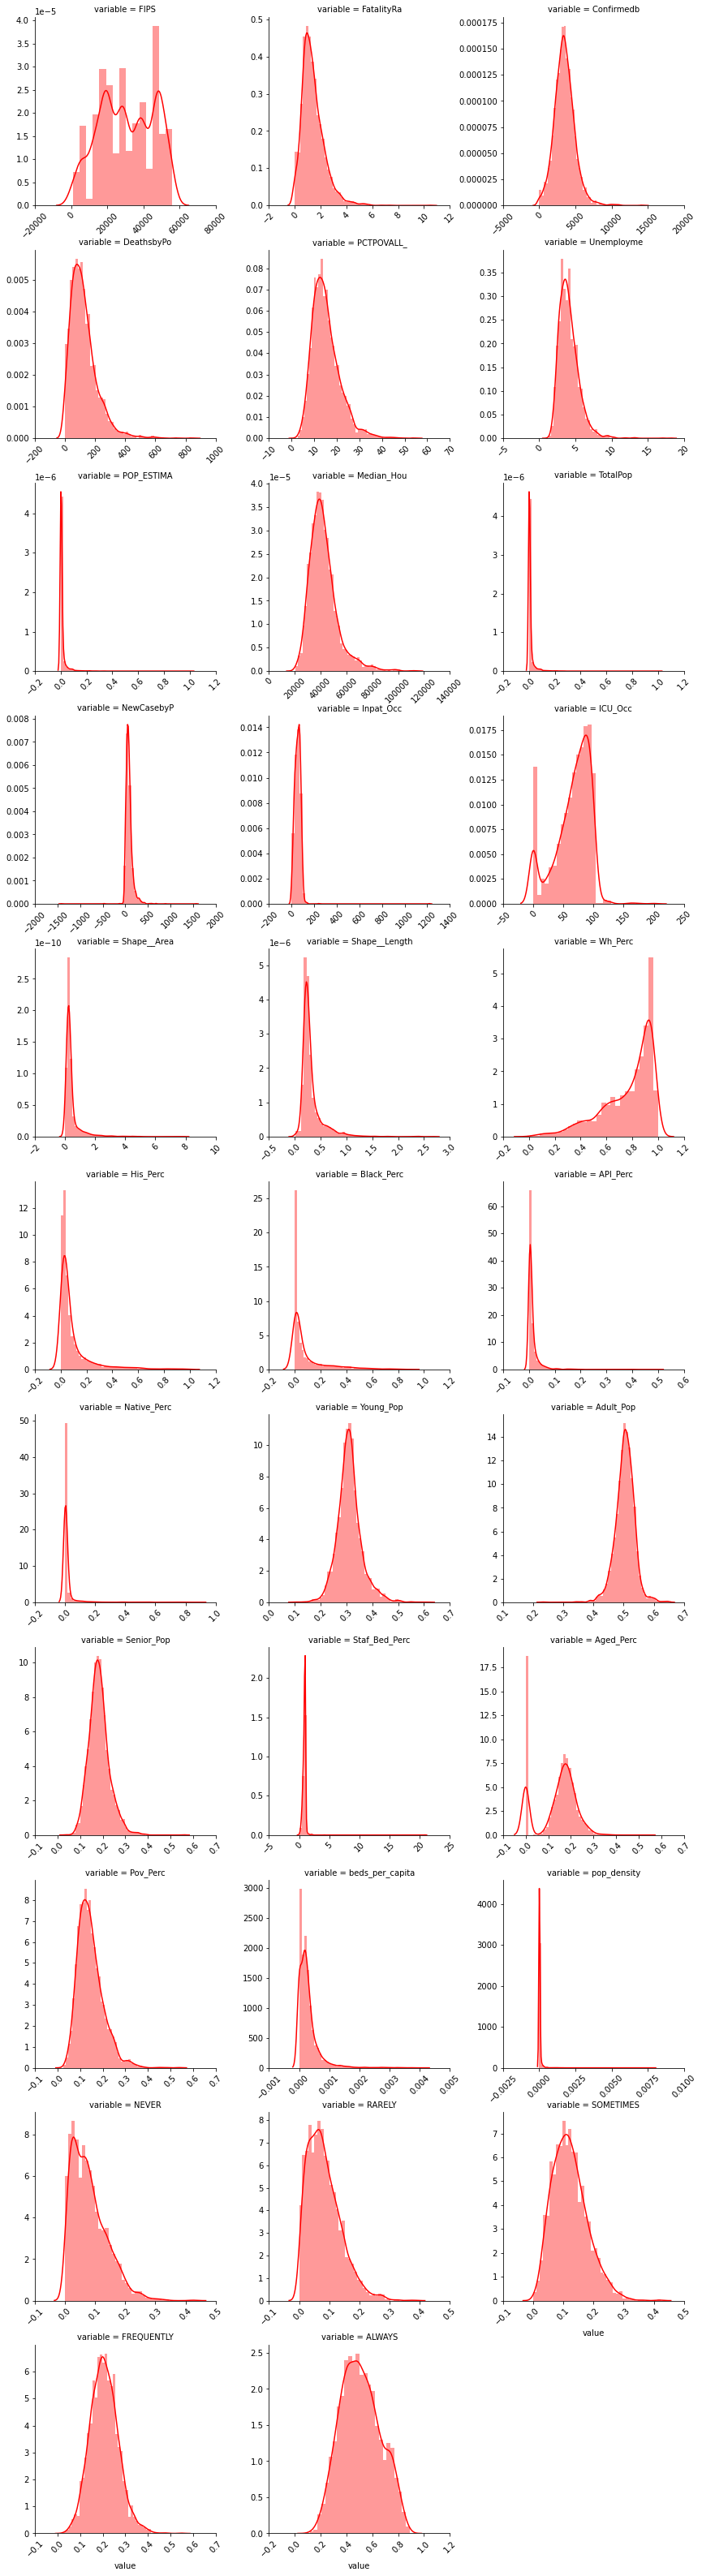

In [69]:
## Display distribution plots of continuous variables using FacetGrid and distplot

con_2 = pd.melt(df, value_vars = feat_col)
g = sns.FacetGrid(con_2, col='variable', col_wrap=3, sharex=False, sharey=False, height=4)
g = g.map(sns.distplot, 'value', color='r')
g.set_xticklabels(rotation=45)